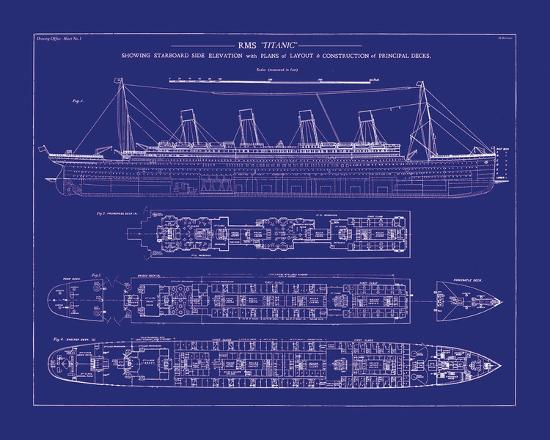

## 🚢 Titanic w/ TabTransformer & XGBoost + Optuna

Мне было интересно добиться наиболее большого результата для себя, поэтому данный код претерпел множество изменений я изучал, каким образом этот челлендж решают другие участники, проанализировал информацию на Stackoverflow и Kaggle. Тем не менее, я, наверное, выбрал не самый эффективный подход, но, наверное, самый интересный для себя.

# Titanic Challenge

Мы будем использовать XGBoost и TabTransformers для предиктов в датасете Титаника. Для подбора гиперпараметров воспользуемся брутфорсом и подберем оптимальные с помощью библиотеки Optuna.

XGBoost значительно превосходит линейную регрессию, которая предполагает, что все признаки влияют на целевую переменную линейно (что далеко не всегда так) XGBoost основана на градиентном бустинге деревьев решений. TabTransformer – это архитектура, вдохновлённая трансформерами, но адаптированная для табличных данных. Лучше работает с категориальными признаками, так как кодирует их в эмбеддинги и анализирует связи между ними. Улавливает сложные взаимодействия признаков, которые трудно моделировать с помощью традиционных методов, таких как XGBoost.

Ансамблирование – это метод при котором мы комбинирвем предсказания нескольких моделей, чтобы получить более точный результат. Optuna – библиотека для автоматического подбора гиперпараметров, которая поможет нам найти лучшие параметры, т.к. ручной подбор гиперпараметров – это долго и неэффективно.
Есть также перебор по сетке, который проверяет все возможные комбинации, но требует гораздо больше вычислений. Optuna использует умный поиск, который быстрее находит оптимальные параметры.

Установим необходимые библиотеки

In [1]:
!pip install transformers
!pip install tab-transformer-pytorch
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 33.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

И импортируем всё

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from tab_transformer_pytorch import TabTransformer
import xgboost as xgb
import optuna
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from sklearn.calibration import calibration_curve

Скачаем датасет

In [3]:
!wget -O train.csv https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv

--2025-03-04 17:43:19--  https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60302 (59K) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]  58.89K  --.-KB/s    in 0.008s  

2025-03-04 17:43:19 (7.11 MB/s) - ‘train.csv’ saved [60302/60302]



Обработаем датасет

In [4]:
data = pd.read_csv("train.csv")

# заполняем пропущенные значения
data['Age'].fillna(data['Age'].median(), inplace=True)  # заменяем пропущенный возраст на медиану
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)  # заполняем порт посадки наиболее частым значением
data['Fare'].fillna(data['Fare'].median(), inplace=True)  # заменяем пропущенную стоимость билета на медиану
#было решено ничего не дропать
# извлекаем и нормализуем title (подсмотрел в другом ноутбуке)
data['Title'] = data['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
data['Title'] = data['Title'].replace(['Mlle', 'Ms'], 'Miss')  # объединяем схожие
data['Title'] = data['Title'].replace(['Mme'], 'Mrs')
data['Title'] = data['Title'].replace(['Don', 'Sir', 'Jonkheer', 'Countess', 'Dona', 'Lady'], 'Noble')  #дворяне
data['Title'] = data['Title'].replace(['Dr', 'Rev', 'Col', 'Major', 'Capt'], 'Officer')  # объединяем титулы офицеров
# возможно сделлать доп признаки например
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1  # размер семьи (+1 тк не забываем добавить самого человека для которого считаем размер семьи)
data['Deck'] = data['Cabin'].fillna("U").apply(lambda x: x[0])  #ищем первую буквы кабины, если неизвестно, то U
data['TicketPrefix'] = data['Ticket'].apply(lambda x: x.split()[0] if not x.isdigit() else 'None')  #префикс билета
data['Fare_Per_Person'] = data['Fare'] / data['FamilySize']  # стоимость билета на человека
# выбираем признаки для обучения
categorical_columns = ["Pclass", "Sex", "Embarked", "Title", "Deck", "TicketPrefix"]  # категориальные
continuous_columns = ["Age", "Fare", "FamilySize", "Fare_Per_Person"]  # числовые
data = data[categorical_columns + continuous_columns + ["Survived"]]  #  итоговый датасет

# кодируем категориальные признаки
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])  # категории в числовые значения

<ipython-input-4-ffd32db2372c>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Age'].fillna(data['Age'].median(), inplace=True)  # заменяем пропущенный возраст на медиану
<ipython-input-4-ffd32db2372c>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 

Подготовим к работе с XGBoost и TabTransformers

In [5]:
#выделяем признаки и целевую переменную, для нас важно выжил чел или нет
X = data[categorical_columns + continuous_columns]
y = data["Survived"]
# разбиение на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scaler = StandardScaler() #стандартизация непрерывных признаков для лучшей сходимости модели
X_train[continuous_columns] = scaler.fit_transform(X_train[continuous_columns])
X_test[continuous_columns]  = scaler.transform(X_test[continuous_columns])
for col in categorical_columns:
    X_train[col] = X_train[col].astype(int) #в целое число
    X_test[col]  = X_test[col].astype(int)

X_train_np = X_train.copy() #для XGBoost
X_test_np  = X_test.copy()

X_train_cat_np = X_train[categorical_columns].values # для tabtransformer: разделяем категориальные и непрерывные признаки
X_train_cont_np = X_train[continuous_columns].values
X_test_cat_np  = X_test[categorical_columns].values
X_test_cont_np  = X_test[continuous_columns].values

X_train_cat = torch.tensor(X_train_cat_np, dtype=torch.long) #преобразование данных в тензоры для работы с pytorch
X_train_cont = torch.tensor(X_train_cont_np, dtype=torch.float32)
X_test_cat = torch.tensor(X_test_cat_np, dtype=torch.long)
X_test_cont = torch.tensor(X_test_cont_np, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test.values, dtype=torch.float32)

cat_dims = tuple(int(X_train[col].max() + 1) for col in categorical_columns) #так и не понял зачем +1, но для размерности, главное что работает

cont_stats = []
for col in continuous_columns:
    mean = X_train[col].mean() #среднее и стандартное отклонение
    std = X_train[col].std()
    cont_stats.append([mean, std])
cont_mean_std = torch.tensor(cont_stats, dtype=torch.float32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Код реализует функцию оптимизации гиперпараметров с использованием optuna. /Сначала с помощью trial.suggest_* выбираются значения гиперпараметров, затем данные делятся на обучающую и валидационную выборки.

Модель tabtransformer обучается на данных в течение нескольких эпох, после чего вычисляются предсказания на валидационном наборе.
Параллельно обучается модель xgboost на тех же данных, и затем предсказания обеих моделей объединяются с помощью взвешенного среднего, где вес определяется гиперпараметром blend_weight.
Итоговая точность на валидационной выборке возвращается как метрика для оптимизации.

In [6]:
def objective(trial):
    # гиперпараметры для tabtransformer
    dim = trial.suggest_categorical('dim', [64, 128])
    depth = trial.suggest_int('depth', 3, 6)
    heads = trial.suggest_int('heads', 4, 8)
    attn_dropout = trial.suggest_float('attn_dropout', 1e-3, 0.5, log=True)
    ff_dropout = trial.suggest_float('ff_dropout', 1e-3, 0.5, log=True)
    lr_nn = trial.suggest_float('lr_nn', 1e-4, 1e-2, log=True)
    # гиперпараметры для xgboost
    xgb_max_depth = trial.suggest_int('xgb_max_depth', 3, 10)
    xgb_learning_rate = trial.suggest_float('xgb_learning_rate', 1e-3, 0.3, log=True)
    xgb_n_estimators = trial.suggest_int('xgb_n_estimators', 50, 300)
    # вес для объединения предсказаний tabtransformer и xgboost
    blend_weight = trial.suggest_float('blend_weight', 0.0, 1.0)
    # разбивка данных на обучающую и валидационную выборки (общая валидация для обеих моделей)
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2)
    # преобразование категориальных и непрерывных признаков в тензоры для tabtransformer
    X_train_split_cat = torch.tensor(X_train_split[categorical_columns].values, dtype=torch.long)
    X_train_split_cont = torch.tensor(X_train_split[continuous_columns].values, dtype=torch.float32)
    y_train_split_tensor = torch.tensor(y_train_split.values, dtype=torch.float32)
    X_val_cat = torch.tensor(X_val_split[categorical_columns].values, dtype=torch.long)
    X_val_cont = torch.tensor(X_val_split[continuous_columns].values, dtype=torch.float32)

    batch_size = 32
    train_dataset = TensorDataset(X_train_split_cat, X_train_split_cont, y_train_split_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    # инициализация модели tabtransformer с подобранными гиперпараметрами
    model = TabTransformer(
        categories = cat_dims,
        num_continuous = len(continuous_columns),
        dim = dim,
        dim_out = 1,
        depth = depth,
        heads = heads,
        attn_dropout = attn_dropout,
        ff_dropout = ff_dropout,
        mlp_hidden_mults = (4, 2),
        mlp_act = nn.ReLU(),
        continuous_mean_std = cont_mean_std
    )
    model.to(device)
    #оптимизатор и функция потерь для обучения нейросети
    optimizer_nn = optim.Adam(model.parameters(), lr=lr_nn)
    criterion = nn.BCEWithLogitsLoss()
    num_epochs = 20  #!!! число эпох для оптимизации гиперпараметров
    model.train()
    for epoch in range(num_epochs):
        for batch_cat, batch_cont, batch_y in train_loader:
            optimizer_nn.zero_grad()  # обнуляем градиенты
            outputs = model(batch_cat.to(device), batch_cont.to(device))  # предсказание модели
            loss = criterion(outputs.squeeze(), batch_y.to(device))  # вычисление ошибки
            loss.backward()  # обратное распространение ошибки
            optimizer_nn.step()  # обновление весов модели
    #перевод модели в режим eval
    model.eval()
    with torch.no_grad():
        nn_outputs = model(X_val_cat.to(device), X_val_cont.to(device))
        nn_probs = torch.sigmoid(nn_outputs.squeeze()).cpu().numpy()
    #обучение модели xgboost
    xgb_model = xgb.XGBClassifier(
        max_depth = xgb_max_depth,
        learning_rate = xgb_learning_rate,
        n_estimators = xgb_n_estimators,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    xgb_model.fit(X_train_split, y_train_split)
    xgb_probs = xgb_model.predict_proba(X_val_split)[:, 1]
    # объединение предсказаний обеих моделей с помощью взвешенного среднего
    ensemble_probs = blend_weight * nn_probs + (1 - blend_weight) * xgb_probs
    ensemble_preds = (ensemble_probs > 0.5).astype(int)
    ensemble_acc = accuracy_score(y_val_split, ensemble_preds)

    return ensemble_acc

# оптимизация гиперпараметров с максимизацией accuracy
cycles = 32 #количество попыток
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=cycles)

# вывод лучших подобранных гиперпараметров
print("Лучший:")
trial = study.best_trial
print(trial.params)

[I 2025-03-04 17:43:20,043] A new study created in memory with name: no-name-98811de8-0349-40b3-92cb-3e69f39eddeb
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:43:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-03-04 17:43:52,212] Trial 0 finished with value: 0.8531468531468531 and parameters: {'dim': 64, 'depth': 5, 'heads': 8, 'attn_dropout': 0.0011774043855184361, 'ff_dropout': 0.0015035213490262216, 'lr_nn': 0.00022486947705743638, 'xgb_max_depth': 3, 'xgb_learning_rate': 0.2995470296431039, 'xgb_n_estimators': 126, 'blend_weight': 0.20694624768924252}. Best is trial 0 with value: 0.8531468531468531.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:44:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-03-04 17:44:11,886] Trial 1 finished with val

Лучший:
{'dim': 128, 'depth': 6, 'heads': 7, 'attn_dropout': 0.2984220532083022, 'ff_dropout': 0.0055573979979157756, 'lr_nn': 0.0018863516462839511, 'xgb_max_depth': 3, 'xgb_learning_rate': 0.00526393545904362, 'xgb_n_estimators': 207, 'blend_weight': 0.6582083721510539}


Используем финальные параметры, учим модель и предсказываем

In [7]:
best_params = trial.params  #получаем лучшие гиперпараметры из оптимизации

#обучение финальной модели TabTransformer
final_model = TabTransformer(
    categories = cat_dims,
    num_continuous = len(continuous_columns),
    dim = best_params['dim'],
    dim_out = 1,
    depth = best_params['depth'],
    heads = best_params['heads'],
    attn_dropout = best_params['attn_dropout'],
    ff_dropout = best_params['ff_dropout'],
    mlp_hidden_mults = (4, 2),
    mlp_act = nn.ReLU(),
    continuous_mean_std = cont_mean_std
)
final_model.to(device)
optimizer_final = optim.Adam(final_model.parameters(), lr=best_params['lr_nn'])
criterion_final = nn.BCEWithLogitsLoss()  #функция потерь для задачи бинарной классификации

# подготовка датасета и даталоадера для финального обучения модели
full_train_dataset = TensorDataset(X_train_cat, X_train_cont, y_train_tensor)
full_train_loader = DataLoader(full_train_dataset, batch_size=32, shuffle=True)

num_epochs_final = 50  #число эпох для финального обучения
final_model.train()  #переводим модель в режим обучения
for epoch in range(num_epochs_final):
    epoch_loss = 0.0
    for batch_cat, batch_cont, batch_y in full_train_loader:
        optimizer_final.zero_grad()  #обнуляем градиенты
        outputs = final_model(batch_cat.to(device), batch_cont.to(device))  # предсказания модели
        loss = criterion_final(outputs.squeeze(), batch_y.to(device))  # вычисляем ошибку
        loss.backward()  # обратное распространение ошибки
        optimizer_final.step()  # обновление весов модели
        epoch_loss += loss.item()

    print(f"epoch {epoch+1}/{num_epochs_final}, loss: {epoch_loss/len(full_train_loader):.4f}")

#обучение финальной модели XGBoost
final_xgb = xgb.XGBClassifier(
    max_depth = best_params['xgb_max_depth'],
    learning_rate = best_params['xgb_learning_rate'],
    n_estimators = best_params['xgb_n_estimators'],
    use_label_encoder=False,
    eval_metric='logloss'
)
final_xgb.fit(X_train_np, y_train)

#оценка работы каждой модели на тестовом наборе
final_model.eval()  #переводим модель TabTransformer в режим оценки
with torch.no_grad():
    test_outputs = final_model(X_test_cat.to(device), X_test_cont.to(device))
    nn_test_probs = torch.sigmoid(test_outputs.squeeze()).cpu().numpy()  #предсказанные

xgb_test_probs = final_xgb.predict_proba(X_test_np)[:, 1]  #предсказанные вероятности от XGBoost

#объединение предсказаний обеих моделей с использованием оптимального веса
blend_weight = best_params['blend_weight']
ensemble_test_probs = blend_weight * nn_test_probs + (1 - blend_weight) * xgb_test_probs
ensemble_test_preds = (ensemble_test_probs > 0.5).astype(int)
test_acc = accuracy_score(y_test, ensemble_test_preds)
print(f"\nfinal ensemble test accuracy: {test_acc:.4f}")

epoch 1/50, loss: 2.2978
epoch 2/50, loss: 0.4601
epoch 3/50, loss: 0.4452
epoch 4/50, loss: 0.4046
epoch 5/50, loss: 0.3861
epoch 6/50, loss: 0.4089
epoch 7/50, loss: 0.3787
epoch 8/50, loss: 0.3988
epoch 9/50, loss: 0.4041
epoch 10/50, loss: 0.3899
epoch 11/50, loss: 0.4012
epoch 12/50, loss: 0.3652
epoch 13/50, loss: 0.3462
epoch 14/50, loss: 0.3483
epoch 15/50, loss: 0.3528
epoch 16/50, loss: 0.3465
epoch 17/50, loss: 0.3577
epoch 18/50, loss: 0.3485
epoch 19/50, loss: 0.3498
epoch 20/50, loss: 0.3497
epoch 21/50, loss: 0.3733
epoch 22/50, loss: 0.3590
epoch 23/50, loss: 0.4305
epoch 24/50, loss: 0.4057
epoch 25/50, loss: 0.3639
epoch 26/50, loss: 0.3790
epoch 27/50, loss: 0.3827
epoch 28/50, loss: 0.3548
epoch 29/50, loss: 0.3532
epoch 30/50, loss: 0.3639
epoch 31/50, loss: 0.3801
epoch 32/50, loss: 0.3953
epoch 33/50, loss: 0.3748
epoch 34/50, loss: 0.3973
epoch 35/50, loss: 0.3934
epoch 36/50, loss: 0.3624
epoch 37/50, loss: 0.3866
epoch 38/50, loss: 0.3949
epoch 39/50, loss: 0.

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:03:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Выводим графики


emodel eval:
accuracy: 0.8268156424581006
              precision    recall  f1-score   support

           0       0.81      0.93      0.87       107
           1       0.87      0.67      0.76        72

    accuracy                           0.83       179
   macro avg       0.84      0.80      0.81       179
weighted avg       0.83      0.83      0.82       179



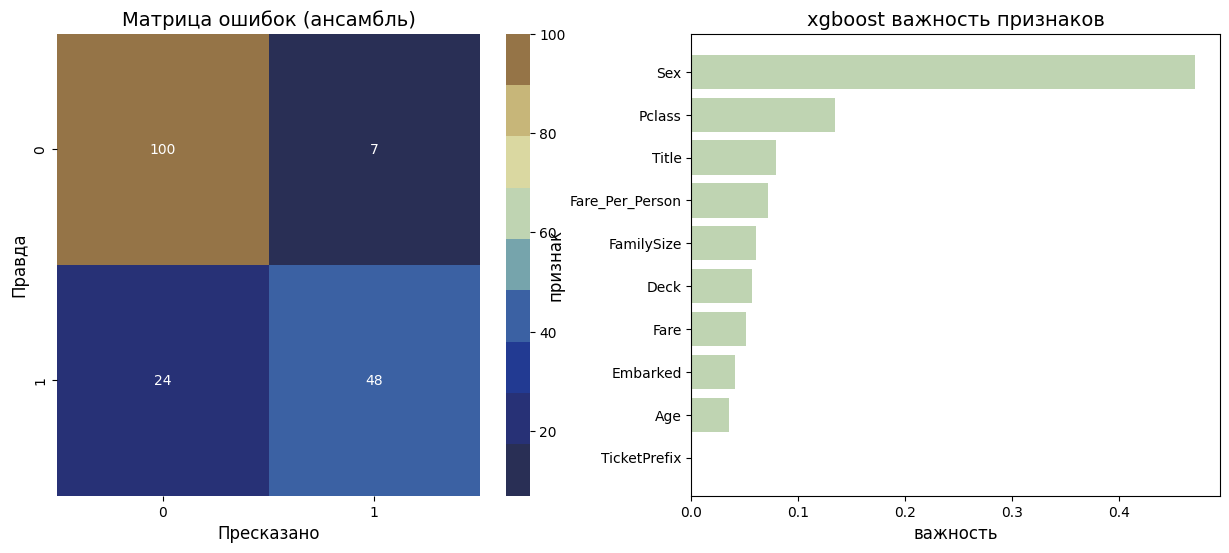

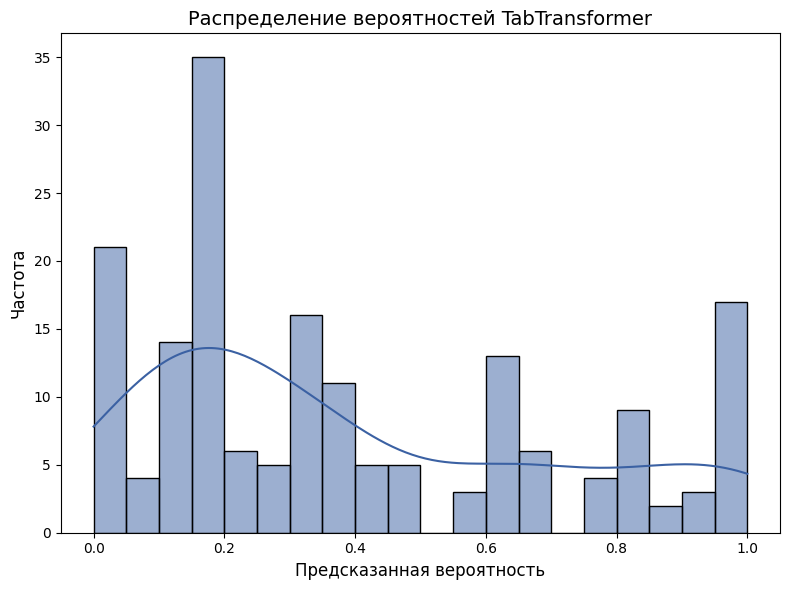

In [8]:
cm = ["#273176", "#3B61A3", "#76A4AC", "#BFD4B2", "#DAD8A1"]
gradient = ["#292F55", "#273176", "#223A92", "#3B61A3", "#76A4AC", "#BFD4B2", "#DAD8A1", "#C7B679", "#957447"]

#вывод отчёта по классификации для ансамблевой модели
print("\nemodel eval:")
print("accuracy:", test_acc)
print(classification_report(y_test, ensemble_test_preds))

#вычисление confusion matrix
conf_matrix_ens = confusion_matrix(y_test, ensemble_test_preds)

#получение важности признаков из модели xgboost
importances = final_xgb.feature_importances_
features = X_train_np.columns  #имена признаков
importances_df = pd.DataFrame({'feature': features, 'importance': importances})
importances_df.sort_values(by='importance', ascending=True, inplace=True)


#создание фигуры с двумя информативными подграфиками
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

#построение тепловой карты матрицы ошибок
sns.heatmap(conf_matrix_ens, annot=True, fmt="d", cmap=sns.color_palette(gradient), ax=axes[0])
axes[0].set_title("Матрица ошибок (ансамбль)", fontsize=14)
axes[0].set_xlabel("Пресказано", fontsize=12)
axes[0].set_ylabel("Правда", fontsize=12)

#построение диаграммы важности признаков для xgboost
axes[1].barh(importances_df['feature'], importances_df['importance'], color=cm[3])
axes[1].set_title("xgboost важность признаков", fontsize=14)
axes[1].set_xlabel("важность", fontsize=12)
axes[1].set_ylabel("признак", fontsize=12)

# построение гистограммы распределения предсказанных вероятностей от модели TabTransformer
fig2, ax2 = plt.subplots(figsize=(8, 6))
sns.histplot(nn_test_probs, bins=20, kde=True, color=cm[1], ax=ax2)
ax2.set_title("Распределение вероятностей TabTransformer", fontsize=14)
ax2.set_xlabel("Предсказанная вероятность", fontsize=12)
ax2.set_ylabel("Частота", fontsize=12)

plt.tight_layout()
plt.show()